# Movie Recommender System
## Data Citation
### The MovieLens dataset used in this notebook is provided by GroupLens Research at the University of Minnesota.
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872

## Where to Get the Dataset

### Smaller Version

A smaller version of the dataset (suitable for quick experiments and local development) is available at:
[ml-latest-small.zip](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

### Larger Version

As of the time of writing, the most recent and largest version of the dataset is available at:
[ml-32m.zip](https://files.grouplens.org/datasets/movielens/ml-32m.zip)

## How to Use the Dataset

1. Download one of the dataset versions above.
2. Unzip the file into the `data/raw/` directory of this repository.
3. After extraction, you should see the following files:
    - `movies.csv`
    - `ratings.csv`
    - `links.csv`
    - `tags.csv`

## Code Style

This notebook uses the [Black](https://black.readthedocs.io/en/stable/) code formatter to ensure readability and consistency across the whole codebase.

All Python scripts and notebooks are formatted with `black` using default settings.

## Setting Up Project and Data Paths

Define the directory structure and file paths used in this notebook.

In [1]:
import os


NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
PROJECT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, "../.."))  # app/notebooks
RAW_DATA_DIRECTORY = os.path.join(PROJECT_DIR, "app/data/raw")

MOVIES_CSV_PATH = os.path.join(RAW_DATA_DIRECTORY, "movies.csv")
RATINGS_CSV_PATH = os.path.join(RAW_DATA_DIRECTORY, "ratings.csv")
LINKS_CSV_PATH = os.path.join(RAW_DATA_DIRECTORY, "links.csv")
TAGS_CSV_PATH = os.path.join(RAW_DATA_DIRECTORY, "tags.csv")

In [2]:
def verify_dataset_files_exist() -> None:
    """Checks if all required MovieLens dataset files exist.

    Returns:
        None
    """

    required_files = {
        "movies.csv": MOVIES_CSV_PATH,
        "ratings.csv": RATINGS_CSV_PATH,
        "links.csv": LINKS_CSV_PATH,
        "tags.csv": TAGS_CSV_PATH,
    }

    missing_files = [
        name for name, path in required_files.items() if not os.path.isfile(path)
    ]

    if missing_files:
        raise FileNotFoundError(
            f"Missing required dataset files: {', '.join(missing_files)}"
        )

In [3]:
verify_dataset_files_exist()

## Loading and Exploring Raw Data

Load the MovieLens dataset files into Pandas DataFrames and display the first few rows of each to verify that the data was read correctly.

In [4]:
import pandas as pd


movies_df = pd.read_csv(MOVIES_CSV_PATH)
ratings_df = pd.read_csv(RATINGS_CSV_PATH)
links_df = pd.read_csv(LINKS_CSV_PATH)
tags_df = pd.read_csv(TAGS_CSV_PATH)

### Movies Dataset

In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Ratings Dataset

In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Links Dataset

In [7]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Tags Dataset

In [8]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Exploratory Data Visualization

Visualize key characteristics and distributions of the MovieLens datasets to better understand the data structure.

In [9]:
import matplotlib.pyplot as plt

### Movie Genre Popularity

Shows the number of movies per genre in the dataset.

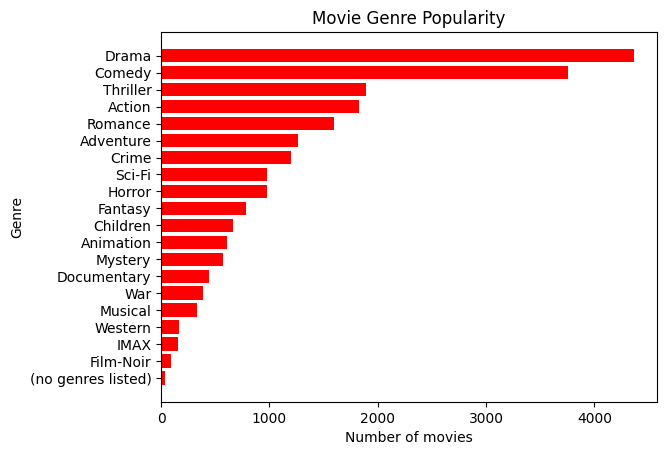

In [10]:
genre_counts = movies_df["genres"].str.split("|").explode().value_counts()

plt.barh(genre_counts.index, genre_counts.values, color="red")
plt.title("Movie Genre Popularity")
plt.xlabel("Number of movies")
plt.ylabel("Genre")
plt.gca().invert_yaxis()
plt.show()

### Distribution of Movie Ratings

Shows how often each rating score appears in the dataset.

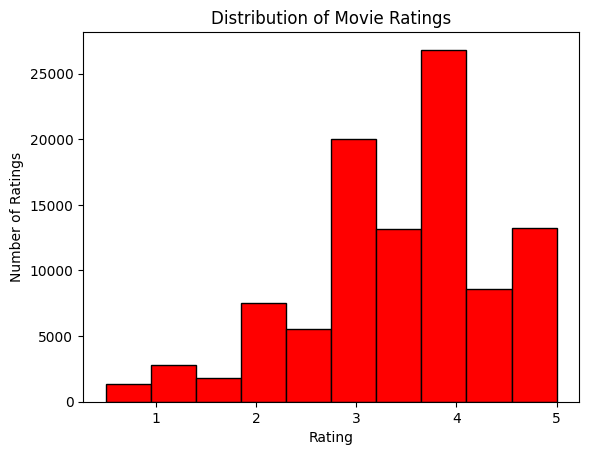

In [11]:
ratings_df["rating"].hist(color="red", edgecolor="black")

plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.grid(False)
plt.show()

### Number of Ratings per Movie

Shows how many ratings movies have in the dataset.

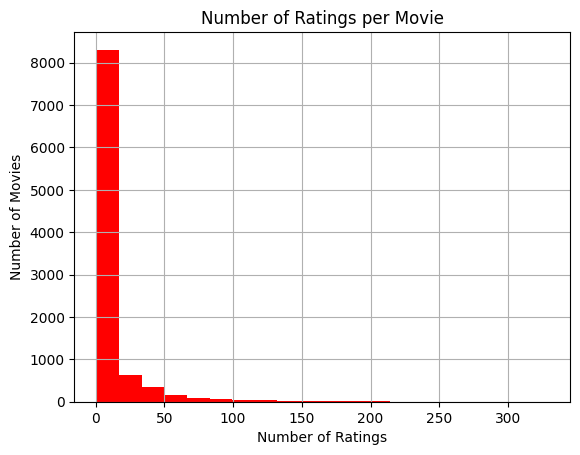

In [12]:
ratings_per_movie = ratings_df["movieId"].value_counts()
ratings_per_movie.hist(bins=20, color="red")

plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()

### Distribution of Number of Ratings per User

Shows number of users grouped by amount of ratings they have given.

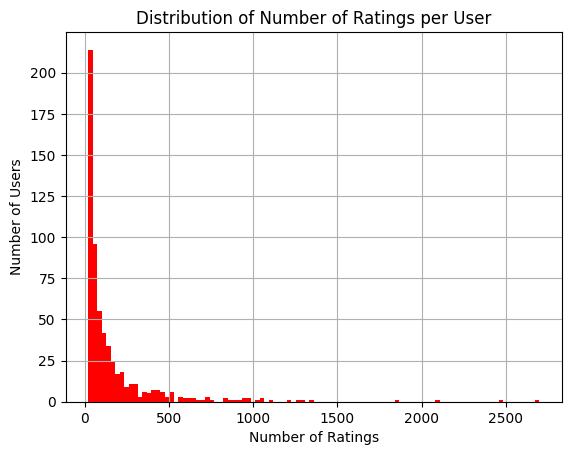

In [13]:
ratings_per_user = ratings_df["userId"].value_counts()
ratings_per_user.hist(bins=100, color="red")

plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

### Top 10 Most Rated Movies

Shows movies with the greatest user rating activity.

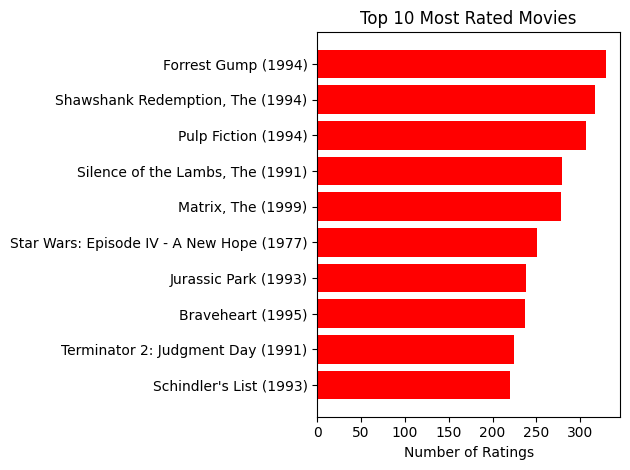

In [14]:
top_movies = ratings_df["movieId"].value_counts().head(10)
top_movies_titles = movies_df.set_index("movieId").loc[top_movies.index]["title"]

plt.barh(top_movies_titles[::-1], top_movies.values[::-1], color="red")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.tight_layout()
plt.show()

### Top 10 Highest Rated Movies

Shows 10 top-rated movies, filtered by minimum number of ratings.

To avoid displaying movies with very few ratings but a perfect score (e.g., only one rating of 5.0), a constant MIN_RATINGS is set to filter out less reliable results.

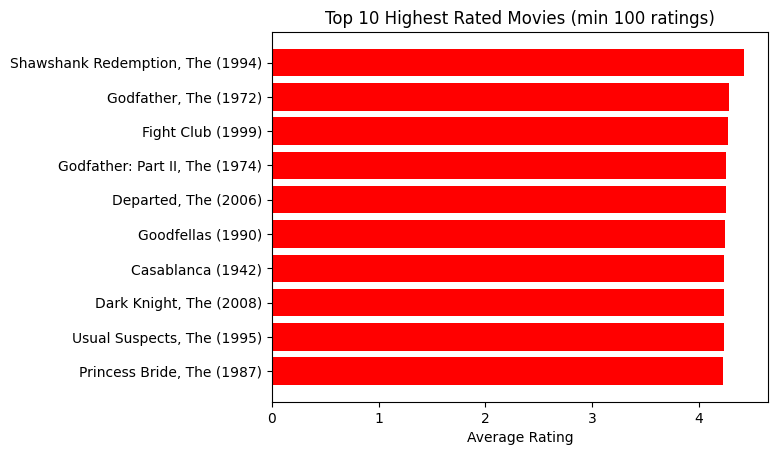

In [15]:
MIN_RATINGS = 100


movie_stats = ratings_df.groupby("movieId").agg({"rating": ["mean", "count"]})
movie_stats.columns = ["mean_rating", "rating_count"]

popular_movies = movie_stats[movie_stats["rating_count"] >= MIN_RATINGS]

top10_movies = popular_movies.sort_values("mean_rating", ascending=False).head(10)

top10_movies = top10_movies.merge(
    movies_df[["movieId", "title"]], left_index=True, right_on="movieId"
)

plt.barh(top10_movies["title"], top10_movies["mean_rating"], color="red")
plt.xlabel("Average Rating")
plt.title(f"Top 10 Highest Rated Movies (min {MIN_RATINGS} ratings)")
plt.gca().invert_yaxis()
plt.show()

### Top 10 Most Used Tags

Shows tags with the highest number of uses by users.

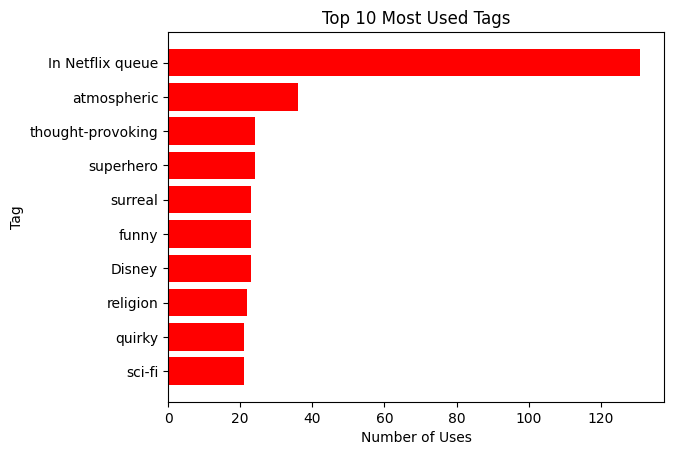

In [16]:
tag_counts = tags_df["tag"].value_counts().head(10)

plt.barh(tag_counts.index, tag_counts.values, color="red")
plt.title("Top 10 Most Used Tags")
plt.xlabel("Number of Uses")
plt.ylabel("Tag")
plt.gca().invert_yaxis()
plt.show()

## Cleaning the Data

Performing basic data cleaning before further operations. This includes removing unnecessary characters and columns.

In [17]:
def drop_parenthesis(string: str) -> str:
    """Removes all parentheses from the input string.

    Args:
        string (str):
            A string potentially containing "(" and/or ")".

    Returns:
        str:
            A copy of the input string with all "(" and ")" characters removed.
    """

    return string.replace("(", "").replace(")", "")

### Cleaning Movie Titles

Remove parentheses from movie titles to simplify the text.

In [18]:
movies_df["title"] = movies_df["title"].apply(drop_parenthesis)

In [19]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji 1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men 1995,Comedy|Romance
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II 1995,Comedy


### Removing Timestamps and User IDs

Remove the `timestamp` column from both the ratings and tags datasets, and remove `userId` from tags, as it is unnecessary for further analysis.

In [20]:
ratings_df = ratings_df.drop("timestamp", axis=1)

In [21]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [22]:
tags_df = tags_df.drop(["timestamp", "userId"], axis=1)

In [23]:
tags_df.head()

,movieId,tag
0,60756,funny
1,60756,Highly quotable
2,60756,will ferrell
3,89774,Boxing story
4,89774,MMA


### Cleaning Links

Drop the `imdbId` column and convert `tmdbId` column to `Int64` type.

In [24]:
links_df = links_df.drop("imdbId", axis=1)
links_df["tmdbId"] = links_df["tmdbId"].astype("Int64")

In [25]:
links_df.head()

,movieId,tmdbId
0,1,862
1,2,8844
2,3,15602
3,4,31357
4,5,11862


## Combining Data

### Grouping Tags

To support future recommendations, all user-provided tags for each movie have been grouped into a single field.

For example, if `movieId = 1` had two separate tags - `funny` and `animation` — they are now combined into one string: `funny animation` in the new `tags` column.

In [26]:
def unique_words_preserve_order(tags_series: pd.Series) -> str:
    """Concatenates unique words from a Series of tags while preserving their order.

    This function processes a pandas Series of tag strings, removes any parentheses,
    splits each tag into individual words, and returns a single string of unique words
    in the order they appear.

    Args:
        tags_series (pd.Series):
            A Series containing tag strings associated with a movie

    Returns:
        str:
            A single space-separated string of unique words in original order.
    """

    words = []
    seen = set()

    for tag in tags_series:
        tag = drop_parenthesis(tag)

        for word in tag.split():
            if word not in seen:
                seen.add(word)
                words.append(word)

    return " ".join(words)

In [27]:
tags_df["tag"] = tags_df["tag"].fillna("").astype(str).str.lower().str.strip()

tags_df = (
    tags_df.groupby("movieId")["tag"]
    .apply(unique_words_preserve_order)
    .reset_index()
    .rename(columns={"tag": "tags"})
)

In [28]:
tags_df.head()

,movieId,tags
0,1,pixar fun
1,2,fantasy magic board game robin williams
2,3,moldy old
3,5,pregnancy remake
4,7,remake


### Merging Tags and Links

Merge grouped tags and TMDB IDs to the movie metadata using `movieId` as the key.

In [29]:
movies_df = movies_df.merge(tags_df, on="movieId", how="left").fillna("")
movies_df = movies_df.merge(links_df, on="movieId", how="left").dropna(
    subset=["tmdbId"]
)

In [30]:
movies_df.head()

,movieId,title,genres,tags,tmdbId
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,pixar fun,862
1,2,Jumanji 1995,Adventure|Children|Fantasy,fantasy magic board game robin williams,8844
2,3,Grumpier Old Men 1995,Comedy|Romance,moldy old,15602
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance,,31357
4,5,Father of the Bride Part II 1995,Comedy,pregnancy remake,11862


### Adding Rating Statistics

Calculate and merge average ratings and rating counts for each movie.

In [31]:
average_ratings_df = (
    ratings_df.groupby("movieId")["rating"]
    .mean()
    .reset_index()
    .rename(columns={"rating": "average_rating"})
)

rating_counts_df = (
    ratings_df.groupby("movieId")["rating"]
    .count()
    .reset_index()
    .rename(columns={"rating": "rating_count"})
)

In [32]:
average_ratings_df.head()

,movieId,average_rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


In [33]:
rating_counts_df.head()

,movieId,rating_count
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [34]:
movies_df = movies_df.merge(average_ratings_df, on="movieId", how="left")
movies_df = movies_df.merge(rating_counts_df, on="movieId", how="left")

movies_df["average_rating"] = movies_df["average_rating"].fillna(0.0)
movies_df["rating_count"] = movies_df["rating_count"].fillna(0).astype(int)

In [35]:
movies_df.head()

,movieId,title,genres,tags,tmdbId,average_rating,rating_count
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,pixar fun,862,3.920930,215
1,2,Jumanji 1995,Adventure|Children|Fantasy,fantasy magic board game robin williams,8844,3.431818,110
2,3,Grumpier Old Men 1995,Comedy|Romance,moldy old,15602,3.259615,52
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance,,31357,2.357143,7
4,5,Father of the Bride Part II 1995,Comedy,pregnancy remake,11862,3.071429,49


### Generating Weighted Genres

Multiply each genre based on a fixed weight to reflect its importance in text-based similarity calculations.

In [36]:
def create_weighted_genres(genres_string: str | None, weight: int) -> str:
    """Generates a space-separated string of genres repeated `weight` times.

    Cleans the input by removing hyphens and handles empty or missing input safely.

    Args:
        genres_string (str | None):
            A string containing genres separated by "|", like "Action|Sci-Fi|Drama".
        weight (int):
            How many times to repeat the genres.

    Returns:
        str:
            A weighted and cleaned genre string.
            For example, "Action SciFi Drama Action SciFi Drama ...".
    """

    if not isinstance(genres_string, str) or not genres_string.strip():
        return ""

    processed_genres = [
        genre.replace("-", "") for genre in genres_string.split("|") if genre.strip()
    ]

    return (" ".join(processed_genres) + " ") * weight

In [37]:
GENRE_WEIGHT = 3


movies_df["genres_weighted"] = (
    movies_df["genres"]
    .apply(lambda x: create_weighted_genres(x, GENRE_WEIGHT))
    .str.strip()
)

In [38]:
movies_df.head()

,movieId,title,genres,tags,tmdbId,average_rating,rating_count,genres_weighted
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,pixar fun,862,3.920930,215,Adventure Animation Children Comedy Fantasy Ad...
1,2,Jumanji 1995,Adventure|Children|Fantasy,fantasy magic board game robin williams,8844,3.431818,110,Adventure Children Fantasy Adventure Children ...
2,3,Grumpier Old Men 1995,Comedy|Romance,moldy old,15602,3.259615,52,Comedy Romance Comedy Romance Comedy Romance
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance,,31357,2.357143,7,Comedy Drama Romance Comedy Drama Romance Come...
4,5,Father of the Bride Part II 1995,Comedy,pregnancy remake,11862,3.071429,49,Comedy Comedy Comedy


### Creating Movie Profiles

Merge the movie title, weighted genres, and tags into a single textual representation for each movie.

In [39]:
movies_df["movie_profile"] = (
    movies_df["title"].fillna("")
    + " "
    + movies_df["genres_weighted"].fillna("")
    + " "
    + movies_df["tags"].fillna("")
)

In [40]:
movies_df.head()

,movieId,title,genres,tags,tmdbId,average_rating,rating_count,genres_weighted,movie_profile
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,pixar fun,862,3.920930,215,Adventure Animation Children Comedy Fantasy Ad...,Toy Story 1995 Adventure Animation Children Co...
1,2,Jumanji 1995,Adventure|Children|Fantasy,fantasy magic board game robin williams,8844,3.431818,110,Adventure Children Fantasy Adventure Children ...,Jumanji 1995 Adventure Children Fantasy Advent...
2,3,Grumpier Old Men 1995,Comedy|Romance,moldy old,15602,3.259615,52,Comedy Romance Comedy Romance Comedy Romance,Grumpier Old Men 1995 Comedy Romance Comedy Ro...
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance,,31357,2.357143,7,Comedy Drama Romance Comedy Drama Romance Come...,Waiting to Exhale 1995 Comedy Drama Romance Co...
4,5,Father of the Bride Part II 1995,Comedy,pregnancy remake,11862,3.071429,49,Comedy Comedy Comedy,Father of the Bride Part II 1995 Comedy Comedy...


## Feature Extraction and Similarity Computation

Use TF-IDF vectorization and cosine similarity to create a numerical representation of movies based on textual metadata and measure their similarity.

### Vectorizing Movie Metadata with TF-IDF

Transform the textual movie profiles into numerical feature vectors using the TF-IDF algorithm, considering unigrams and bigrams.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df["movie_profile"])

In [42]:
tfidf_matrix.shape

(9734, 4455)

### Computing Cosine Similarity

Compute the pairwise cosine similarity between all movie vectors to quantify how similar the movies are to one another.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity


cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [44]:
cosine_sim.shape

(9734, 9734)

### Indexing Movie Titles

Create a mapping from movie titles to DataFrame indices to allow quick lookup when generating recommendations.

In [45]:
movie_id_to_index = pd.Series(movies_df.index.values, index=movies_df["movieId"])

In [46]:
movie_id_to_index.head()

movieId
1    0
2    1
3    2
4    3
5    4
dtype: int64

## Recommendation System

### Retrieving Movie Title by ID

Provides a helper function to find a movie's title based on its unique movie ID.

In [47]:
def get_movie_title_by_id(movie_id: int, movies_dataframe: pd.DataFrame) -> str | None:
    """Retrieves the title of a movie by its movieId.

    Args:
        movie_id (int):
            The ID of the movie.
        movies_dataframe (pd.DataFrame):
            The dataframe containing movie information.

    Returns:
        str | None:
            The movie title if found, else None.
            For example, "Toy Story 1995"
    """

    movie = movies_dataframe.loc[movies_dataframe["movieId"] == movie_id, "title"]

    if movie.empty:
        return None

    return movie.iloc[0]

### Generating Movie Recommendations

Core recommendation function that finds movies similar to a specified title, applying filters on genres, tags, and rating thresholds to improve relevance.

In [48]:
import numpy as np


def find_movie_recommendations(
    movie_id: int,
    movie_index_map: pd.Series,
    movies_dataframe: pd.DataFrame,
    similarity_matrix: np.ndarray,
    n_recommendations: int = 10,
    target_genres: list[str] = None,
    target_tags: list[str] = None,
    min_rating_count: int = 50,
) -> pd.DataFrame:
    """Recommends movies similar to the given movie based on cosine similarity.

    The function uses a precomputed cosine similarity matrix to find movies most
    similar to the one specified by `movie_id`. Results can be filtered by genre,
    tag, and minimum number of ratings.

    Args:
        movie_id (int):
            The ID of the movie to find recommendations for.
        movie_index_map (pd.Series):
            A mapping from movieId to the corresponding row index in the similarity matrix and movies DataFrame.
        movies_dataframe (pd.DataFrame):
            The DataFrame containing movie metadata, such as title, genres, tags, average ratings, and rating count.
        similarity_matrix (np.ndarray):
            Matrix of cosine similarity scores between movies.
        n_recommendations (int | None):
            Number of recommendations to return.
            Defaults to 10.
        target_genres (list[str] | None):
            List of genres to filter recommendations by.
            If provided, only movies that share at least one of the specified genres will be returned.
        target_tags (list[str] | None):
            List of tags to filter recommendations by.
            If provided, only movies that share at least one of the specified tags will be returned.
        min_rating_count (int | None):
            Minimum number of ratings a recommended movie must have.
            This helps filter out obscure movies with unreliable averages.
            Defaults to 50.

    Returns:
        pd.DataFrame:
            A DataFrame containing recommended movies.
    """

    if movie_id not in movie_index_map:
        raise ValueError(f"Movie ID {movie_id} not found in the dataset.")

    recommendations = []

    target_genres_lower = (
        [genre.strip().lower() for genre in target_genres] if target_genres else []
    )
    target_tags_lower = (
        [tag.strip().lower() for tag in target_tags] if target_tags else []
    )

    movie_index = movie_index_map[movie_id]

    similarity_scores = list(enumerate(similarity_matrix[movie_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[
        1:
    ]  # Remove the first row, as it always is the movie provided by the user.

    for similar_movie_index, similarity_score in similarity_scores:
        movie = movies_dataframe.iloc[similar_movie_index].copy()

        genres = (
            [genre.strip().lower() for genre in movie["genres"].split("|") if genre]
            if pd.notna(movie["genres"])
            else []
        )

        tags = (
            [tag.strip().lower() for tag in movie["tags"].split() if tag]
            if pd.notna(movie["tags"])
            else []
        )

        if target_genres_lower and not any(
            genre in genres for genre in target_genres_lower
        ):
            continue
        if target_tags_lower and not any(tag in tags for tag in target_tags_lower):
            continue
        if movie["rating_count"] < min_rating_count:
            continue

        movie["similarity_score"] = similarity_score
        recommendations.append(movie)

        if len(recommendations) >= n_recommendations:
            break

    if not recommendations:
        raise LookupError(f"No recommendations found for movie ID {movie_id}.")

    recommendations_df = pd.DataFrame(recommendations).sort_values(
        by=["similarity_score", "average_rating"], ascending=[False, False]
    )

    return recommendations_df

### Example Usage

This example demonstrates how to retrieve the movie title for a given `movieId` (only for reference), and how to generate recommendations based on that movie ID.

In [49]:
sample_movie_title = get_movie_title_by_id(296, movies_df)
sample_movie_title

'Pulp Fiction 1994'

In [51]:
movie_recommendations = find_movie_recommendations(
    296, movie_id_to_index, movies_df, cosine_sim
)
movie_recommendations

,movieId,title,genres,tags,tmdbId,average_rating,rating_count,genres_weighted,movie_profile,similarity_score
1296,1732,"Big Lebowski, The 1998",Comedy|Crime,coen brothers black comedy bowling classic cri...,115,3.924528,106,Comedy Crime Comedy Crime Comedy Crime,"Big Lebowski, The 1998 Comedy Crime Comedy Cri...",0.358135
254,293,Léon: The Professional a.k.a. The Professional...,Action|Crime|Drama|Thriller,assassin jean reno hit men action assassinatio...,101,4.018797,133,Action Crime Drama Thriller Action Crime Drama...,Léon: The Professional a.k.a. The Professional...,0.275736
2223,2959,Fight Club 1999,Action|Crime|Drama|Thriller,dark comedy psychology thought-provoking twist...,550,4.272936,218,Action Crime Drama Thriller Action Crime Drama...,Fight Club 1999 Action Crime Drama Thriller Ac...,0.264783
118,145,Bad Boys 1995,Action|Comedy|Crime|Drama|Thriller,,9737,3.245098,51,Action Comedy Crime Drama Thriller Action Come...,Bad Boys 1995 Action Comedy Crime Drama Thrill...,0.241423
520,608,Fargo 1996,Comedy|Crime|Drama|Thriller,based on a true story dark comedy kidnapping s...,275,4.116022,181,Comedy Crime Drama Thriller Comedy Crime Drama...,Fargo 1996 Comedy Crime Drama Thriller Comedy ...,0.239507
827,1089,Reservoir Dogs 1992,Crime|Mystery|Thriller,ensemble cast nonlinear quentin tarantino styl...,500,4.202290,131,Crime Mystery Thriller Crime Mystery Thriller ...,Reservoir Dogs 1992 Crime Mystery Thriller Cri...,0.205558
1685,2268,"Few Good Men, A 1992",Crime|Drama|Thriller,court military,881,3.789474,57,Crime Drama Thriller Crime Drama Thriller Crim...,"Few Good Men, A 1992 Crime Drama Thriller Crim...",0.181466
2993,4011,Snatch 2000,Comedy|Crime|Thriller,,107,4.155914,93,Comedy Crime Thriller Comedy Crime Thriller Co...,Snatch 2000 Comedy Crime Thriller Comedy Crime...,0.179681
3491,4776,Training Day 2001,Crime|Drama|Thriller,,2034,3.794118,51,Crime Drama Thriller Crime Drama Thriller Crim...,Training Day 2001 Crime Drama Thriller Crime D...,0.175481
1915,2542,"Lock, Stock & Two Smoking Barrels 1998",Comedy|Crime|Thriller,,100,4.052239,67,Comedy Crime Thriller Comedy Crime Thriller Co...,"Lock, Stock & Two Smoking Barrels 1998 Comedy ...",0.174416
